# Постановка задачи
### Используя метод переменных направлений решите задачу:

$\left\{\begin{aligned}
\frac{\partial u}{\partial t} = \Delta u , \ ~ 0< x< \frac{\pi}{2} , 0<y<\frac{\pi}{2}\\
\frac{\partial u}{\partial x} \bigg|_{x=0} = 0, \qquad \frac{\partial u}{\partial x} \bigg|_{x=\pi/2} = 0\\
\frac{\partial u}{\partial y} \bigg|_{y=0} = 0, \qquad \frac{\partial u}{\partial y} \bigg|_{y=\pi/2} = 0\\
u\bigg|_{t=0} = cos4x cos2y
\end{aligned}\\
\right. $

# Решение
Импортируем библиотеки:

In [1]:
import numpy as np
import math
import plotly.graph_objects as go

Задаём границы области:

In [2]:
x_begin, x_final = 0, math.pi/2
y_begin, y_final = 0, math.pi/2
T = 1

Задаём кол-во интервалов по пространственным сеткам ($N$ и $M$) и по временной сетке $J$ 

Задаём шаги по координатам и по времени

In [3]:
N = 100
M = 50
J = 50

tau = T/J
h_x = (x_final - x_begin)/(N-1)
h_y = (y_final - y_begin)/(M-1)

Задаём массивы:

По $x$ и по $y$ сетка задаётся с фиктивными узлами для аппроксимации граничных условий Неймана со 2-м порядком аппроксимации

In [4]:
x = np.linspace(x_begin - h_x/2, x_final + h_x/2, N+1)
y = np.linspace(y_begin - h_y/2, y_final + h_y/2, M+1)
t = np.linspace(0, T, J+1)


Создаём массив сеточной функции и заполняем начальное условие

In [5]:
w = np.zeros([J+1, N+1, M+1])
for m in range(M+1):
    for n in range(N+1):
        w[0,n,m] = math.cos(x[n]*4)*math.cos(y[m]*2)

## Численное решение

In [6]:
for j in range(J):
    half = np.zeros((N+1, M+1))          # массив промежуточного слоя j+1/2
    for m in range(1,M):
        # Для каждого m, кроме 0 и М, выполняем алгоритм прогонки
        alpha = np.zeros(N+1)
        beta = np.zeros(N+1)
        c0,b0,f0 = 1,1,0
        aN, cN, fN = 1,1,0
        a,b,c = tau/2/h_x**2, tau/2/h_x**2, (tau/h_x**2 +1)
        alpha[0] = b0/c0
        beta[0] = f0/c0
        for i in range(1, N):
            f_i =-( w[j,i,m] + tau/2/h_y**2*(w[j,i,m+1] - 2*w[j,i,m] + w[j,i,m-1]))
            alpha[i] = b/(c - alpha[i-1]*a)
            beta[i] = (f_i+beta[i-1]*a)/(c - a*alpha[i-1])
        beta[N] = (fN +beta[N-1]*aN)/(cN - aN*alpha[N-1])
        half[N, m] = beta[N]
        for i in range(N-1, -1, -1):
            half[i, m] = alpha[i]*half[i+1, m] + beta[i]
    # Переход на полуцелый слой j+1/2 по направлению х завершён
    # Совершим переход на слой j+1 по направлению у
    for n in range(1,N):
        # Для каждого n, кроме 0 и N, выполняем алгоритм прогонки
        alpha = np.zeros(M+1)
        beta = np.zeros(M+1)
        c0,b0,f0 = 1,1,0
        aN, cN, fN = 1,1,0
        a,b,c = tau/2/h_y**2, tau/2/h_y**2, (tau/h_y**2 +1)
        alpha[0] = b0/c0
        beta[0] = f0/c0
        for i in range(1, M):
            f_i = -(half[n,i] + tau/2/h_x**2*(half[n+1,i] - 2*half[n,i] + half[n-1,i]))
            alpha[i] = b/(c - alpha[i-1]*a)
            beta[i] = (f_i+beta[i-1]*a)/(c - a*alpha[i-1])
        beta[M] = (fN +beta[M-1]*aN)/(cN - aN*alpha[M-1])
        w[j+1,n,M] = beta[M]
        for i in range(M-1, -1, -1):
            w[j+1,n,i] = alpha[i]*w[j+1,n,i+1] + beta[i]
    # Переход на слой j+1 по направлению у завершён
    # Заполним недостающие значения при n = 0, N с помощью граничных условий
    for m in range(M+1):
        w[j+1,0,m] = w[j+1,1,m]
        w[j+1,N,m] = w[j+1,N-1,m]
    # Конец работы по переходу на новый слой   
    

### Аналитическое решение и ошибка

In [7]:
ch = np.zeros((J+1,N+1,M+1))
err = np.zeros((J+1,N+1,M+1))
max = 0
for j in range(J+1):
    for i in range(N+1):
        for k in range(M+1):
            ch[j,i,k] = math.cos(4*x[i])*math.cos(2*y[k])*math.exp(-20*t[j])
            err[j,i,k] = ch[j,i,k] - w[j,i,k]
            if err[j,i,k] > max:
                max = err[j,i,k]
print("Максимальное значение ошибки равно:",max)

Максимальное значение ошибки равно: 0.0024092523808603716


## Построение графиков

In [8]:
fig = go.Figure(data=[go.Surface(z=w[10,:,:], x=y, y=x)])
fig.update_layout(title='Численное решение при t =10*tau ', autosize = True,height = 800,scene = dict(
                     xaxis_title='Y', yaxis_title='X', zaxis_title='W'),)
fig.show()

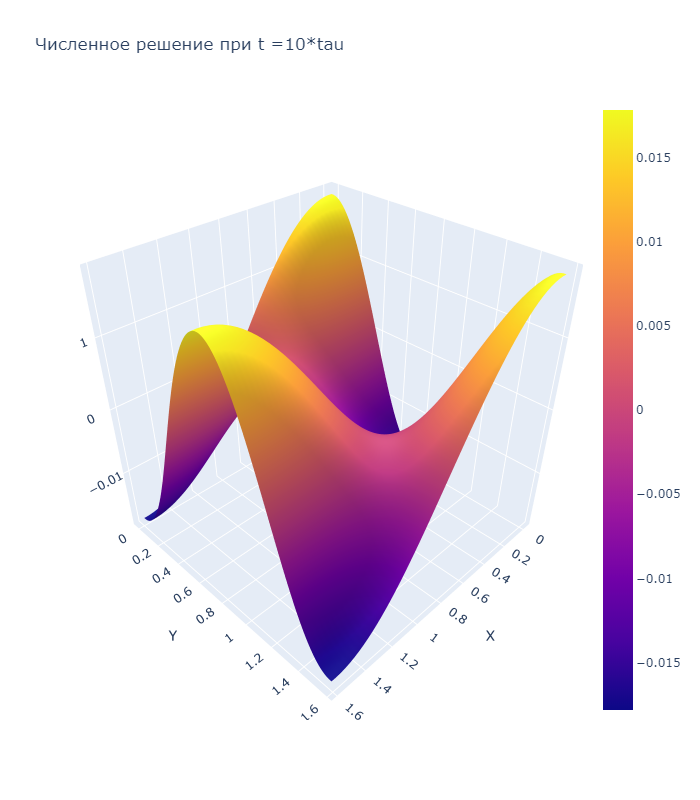

In [9]:
lay = 10
fig1 = go.Figure(data=[go.Surface(z=ch[lay,:,:], x=y, y=x)])
fig1.update_layout(title='Аналитическое решениt при t=10*tau', autosize = True,height = 800,scene = dict(
                     xaxis_title='Y', yaxis_title='X', zaxis_title='Ch'),)

fig2 = go.Figure(data=[go.Surface(z=err[lay,:,:], x=y, y=x)])
fig2.update_layout(title='Ошибка при t=10*tau', autosize = True,height = 800,scene = dict(
                     xaxis_title='Y', yaxis_title='X', zaxis_title='err'),)
fig1.show()
fig2.show()

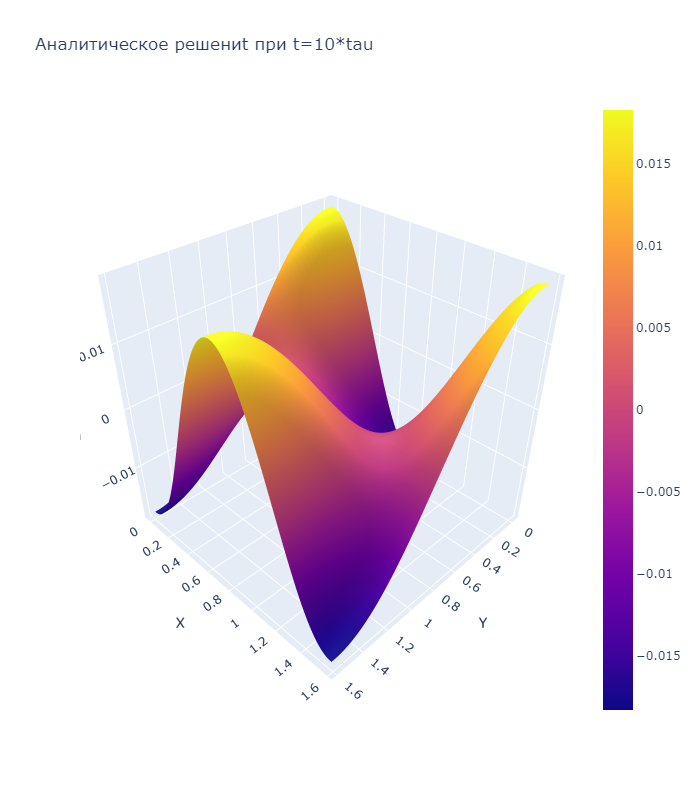

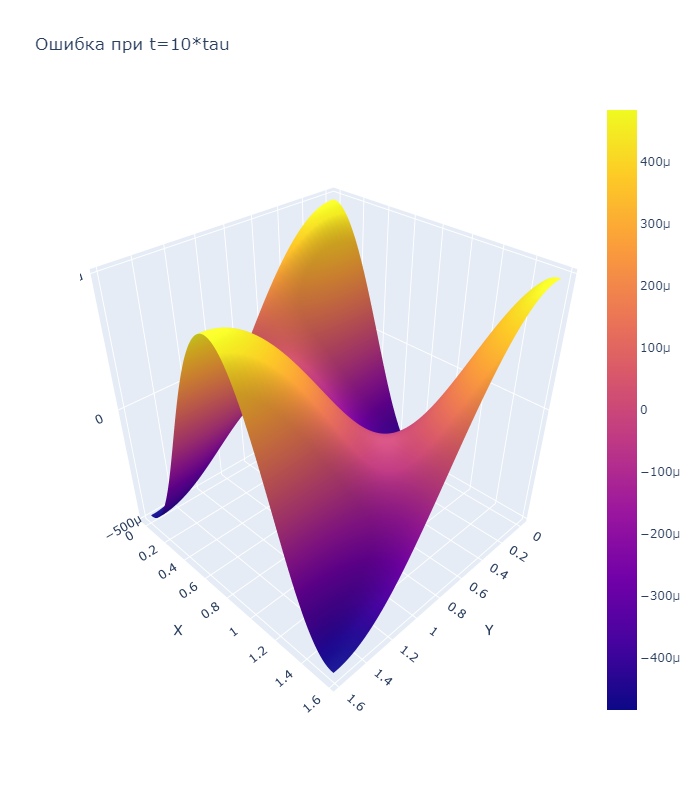